In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#import scipy.special as special
#scipy.special.ellipk 

import mpmath as mpmath
# https://mpmath.org/doc/current/functions/elliptic.html
# https://mpmath.org/doc/current/functions/elliptic.html#jacobi-theta-functions
# mpmath is better than scipy.special

hour = 60*60.0
day = hour*24
degreeperday = (180/np.pi)*day

### goal is to compute spin vector given information from lightcurve/radar fitting

Following Scheere's book 
\begin{align}
k^2  {\rm\ SAM} &= \frac{ (I_y - I_x ) (I_z - I_D )  }
                     { (I_z- I_y ) ( I_D - I_x )   }                
\end{align}
is inverse if LAM. 

$$A_t = \sqrt{\frac{I_D(I_z - I_y) (I_D- I_x)}{I_x I_y I_y}} \frac{1}{\sigma}$$

\begin{align}
\tau = A_t \omega_{\rm eff} t
\end{align}
\begin{align}
P_\psi &= \frac{4 K(k)}{t_{fac} \omega_{\rm eff}}\\
\omega_{\rm eff} &=  \frac{4 K(k)}{A_t P_\psi}
\end{align}

If $I_y < I_D < I_s $ then SAM, $\sigma=1$, $\gamma=k$.
Otherwise LAM and $\sigma=k$, $\gamma=1$. 

In [2]:
# given two ratios of moment of inertia, rotation period, and energy ratio
# computes:
#  mode: which mode of rotation SAM or LAM
#  A_t time scaling factor 
#  k (used in elliptic functions)
#  bigK = K(k) an elliptic function
#  omega_eff effective rotation H = I_D omega_eff, T = I_D omega_eff^2/2
#  n also used in elliptic functions 
#  sigma, gamma -- dependent on whether SAM or LAM
#  taufac a factor giving tau = A_t omega_eff t
#
# ratios
# I_y_ratio = I_y/I_z, I_x_ratio = I_x/I_z, I_D_ratio = I_D/I_z
# T_ratio = E/E_0 or T/T_0 (depending upon notation) = I_z/I_D = 1/I_D_ratio
# often y = intermediate, z=short, x =long axes 
def dostuff(I_y_ratio,I_x_ratio,T_ratio,P_psi):
    I_D_ratio = 1/T_ratio
    k2 = (I_y_ratio-I_x_ratio)*(1.0-I_D_ratio)/((1.-I_y_ratio)*(I_D_ratio-I_x_ratio))
    if ((I_y_ratio < I_D_ratio) and (I_D_ratio <1.0)):
        mode = 'SAM'
        k = np.sqrt(k2)
        sigma = 1.0
        ggamma = k
        
    else:
        mode = 'LAM'
        k = np.sqrt(1./k2)
        sigma = k
        ggamma = 1.0
    m = k**2  # note convention is that m is passed to elliptic functions not k 
    # print(special.ellipk(m), mpmath.ellipk(m)) they agreed!
    bigK= float(mpmath.ellipk(m))  # = K(k) complete elliptic integral first kind 
    A_t = np.sqrt(I_D_ratio*(1.0-I_y_ratio)*(I_D_ratio-I_x_ratio)/(I_x_ratio*I_y_ratio))
    A_t *= 1.0/sigma  #  a factor for scaling time 
    #print('A_t={:.3f}'.format(A_t))
    omega_eff = 4.0*bigK/(A_t*P_psi)
    taufac = A_t*omega_eff  # multiply this by time to get tau 
    n = sigma**2 * (1.0/I_x_ratio) * (I_y_ratio - I_x_ratio)/(1.0 - I_y_ratio)
    # n is useful for computing dphdt below
    return mode,sigma,ggamma,k,bigK,omega_eff,taufac,n,A_t
      

In [3]:
model = 'B18'  # for Apophis
#model = 'L22'  # 


if (model=='L22'):  # from Lee+22 Table 2
    T_ratio = 1.018 # is equal to T/T_0 
    I_D_ratio = 1.0/T_ratio  # is I_D/I_s
    print('I_D/I_s = {:.3f}'.format(I_D_ratio))
    I_i_ratio = 0.962 # I_2/I_3  
    I_l_ratio = 0.64  # I_1/I_3  
    P_psi = 264.18*hour # rotation period
    P_phi = 27.3855*hour

if (model=='B18'):  # from Brozovic+18 supplements
    T_ratio = 1.0254 # is equal to T/T_0 
    I_D_ratio = 1.0/T_ratio  # is I_D/I_s
    print('I_D/I_s = {:.3f}'.format(I_D_ratio))
    I_i_ratio = 0.947 # I_2/I_3  
    I_l_ratio = 0.729  # I_1/I_3  
    P_psi = 265.7*hour # rotation period
    P_phi = 27.45*hour
# Since I_i < I_D <I_s we are in SAM

I_x_ratio = I_l_ratio  #in general true!
I_y_ratio = I_i_ratio

# compute a few quantities and print them out
mode,sigma,ggamma,k,bigK,omega_eff,taufac,n,A_t = dostuff(I_y_ratio,I_x_ratio,T_ratio,P_psi)
print(mode)
print('k={:.3f}'.format(k))
print('omega_eff= {:.3e} (rad/s-1)'.format(omega_eff))
print('BigK={:.3f}'.format(bigK))
print('A_t={:.3f}'.format(A_t))

# mostly using formulas from Scheere's book

I_D/I_s = 0.975
SAM
k=0.643
omega_eff= 5.505e-05 (rad/s-1)
BigK=1.787
A_t=0.136


For SAM $\sigma=1,\gamma=k$. LAM is reversed, $\sigma=k,\gamma=1$. 

\begin{align}
\Omega_x &= \omega_{eff} \sqrt{\frac{I_D}{I_x} \frac{ (I_z-I_D)}{(I_z-I_x)}}\sqrt{1 -\sigma^2 {\rm sn}(\tau,k)^2} \\
\Omega_i &= \omega_{eff} \sqrt{\frac{I_D}{I_y} \frac{ (I_z-I_D)}{(I_z-I_y)}}\sigma  {\rm sn}(\tau,k)\\
\Omega_s &= \omega_{eff} \sqrt{\frac{I_D}{I_z} \frac{(I_D-I_x)}{(I_z-I_x)}} \sqrt{1 -\gamma^2 {\rm sn}(\tau,k)^2}
\end{align}

\begin{align}
\psi &= {\rm atan2} (I_x \Omega_x, I_y \Omega_y) \\
\theta &= {\rm acos} \frac{ I_z \Omega_z }{I_D \omega_{\rm eff}}
\end{align}

\begin{align}
\bar{ \frac{d\phi}{dt}} = \omega_{eff} \frac{I_D}{I_z} 
\left[ 1 + \frac{I_z- I_x}{I_x} \frac{\Pi(K(k),n) }{K(k)}\right]
\end{align}

However here $\Pi$ (third kind elliptical integral) is defined with $n$ having sign opposite to what is in mpmath.ellipi

In [4]:
# computes spin vector and two Euler angles, given tau
def ome_ang(I_y_ratio,I_x_ratio,T_ratio,P_psi,tau):
    mode,sigma,ggamma,k,bigK,omega_eff,taufac,n,A_t = \
        dostuff(I_y_ratio,I_x_ratio,T_ratio,P_psi)
    I_D_ratio = 1.0/T_ratio  # is I_D/I_s
    m = k**2
    sn =  float(mpmath.ellipfun('sn', tau, m)) 
    Omega_x = omega_eff*np.sqrt((I_D_ratio/I_x_ratio)*(1.0 - I_D_ratio)/(1.0-I_x_ratio))*\
        np.sqrt(1.0 - sigma**2 *sn**2)
    Omega_y = omega_eff*np.sqrt((I_D_ratio/I_y_ratio)*(1.0 - I_D_ratio)/(1.0-I_y_ratio))*\
        sigma*sn
    Omega_z = omega_eff*np.sqrt((I_D_ratio/1)*(I_D_ratio-I_x_ratio)/(1.0-I_x_ratio))*\
        np.sqrt(1.0 - ggamma**2 *sn**2)
    psi = np.arctan2(I_x_ratio*Omega_x,I_y_ratio*Omega_y)
    theta = np.arccos(Omega_z/(I_D_ratio*omega_eff))
    return Omega_x,Omega_y,Omega_z,psi,theta

Omega_x,Omega_y,Omega_z,psi,theta = ome_ang(I_y_ratio,I_x_ratio,T_ratio,P_psi,0.3)
print('Omega=({:.4e} ,{:.4e}, {:.4e})(s-1)'.format(Omega_x,Omega_y,Omega_z))
print('psi theta {:.4f} {:.4f} (radians)'.format(psi,theta))
print('psi {:.2f} deg theta {:.2f} deg'.format(psi*180/np.pi,theta*180/np.pi))

Omega=(1.8399e-05 ,1.1219e-05, 5.0882e-05)(s-1)
psi theta 0.9009 0.3244 (radians)
psi 51.62 deg theta 18.59 deg


In [5]:
Hcheck = np.sqrt( (I_x_ratio*Omega_x)**2 + (I_y_ratio*Omega_y)**2 + Omega_z**2)
Hcheck_comp = I_D_ratio*omega_eff
print('H {:.4e} {:.4e}'.format(Hcheck,Hcheck_comp))

Tcheck = I_x_ratio*Omega_x**2 + I_y_ratio*Omega_y**2  + Omega_z**2
Tcheck_comp = I_D_ratio*omega_eff**2
print('T {:.4e} {:.4e}'.format(Tcheck,Tcheck_comp))
# formulas are correct as these agree!

H 5.3682e-05 5.3682e-05
T 2.9549e-09 2.9549e-09


In [6]:
# compute the average dphidt using elliptical integral (third kind)
def compute_phi_bar(I_i_ratio,I_l_ratio,T_ratio,P_psi):
    mode,sigma,ggamma,k,bigK,omega_eff,taufac,n,A_t = \
         dostuff(I_y_ratio,I_x_ratio,T_ratio,P_psi)
    m = k**2
    f1 = (1.0- I_l_ratio)/I_l_ratio
    #phi = bigK
    Pi3 = float(mpmath.ellippi(-n,bigK,m))  # Scheeres def has a -n compared to mpmath
    # third kind of ellip integral 
    dphidt = omega_eff*I_D_ratio*(1.0 + f1*Pi3/bigK);
    return dphidt

bardotphi = compute_phi_bar(I_i_ratio,I_l_ratio,T_ratio,P_psi)
print('bardotphi {:.4e} (rad/s-1)'.format(bardotphi))
P_phi = 2*np.pi/bardotphi
print('P_phi {:.2f} (hour)'.format(P_phi/hour))
# what I get is close to what I integrated below but not good agreement 
# with precession period  by P14 or L22 or B18 which is like 27.5

bardotphi 6.1468e-05 (rad/s-1)
P_phi 28.39 (hour)


In [10]:
# computing dphidt in different ways to check above
# this function computes an intermediate step that can be integrated to get average
def compute_dphidi(I_y_ratio,I_x_ratio,T_ratio,P_psi,tau):
    mode,sigma,ggamma,k,bigK,omega_eff,taufac,n,A_t =\
        dostuff(I_y_ratio,I_x_ratio,T_ratio,P_psi)
    I_D_ratio = 1.0/T_ratio  # is I_D/I_s
    m = k**2
    sn =  float(mpmath.ellipfun('sn', tau, m)) 
    Omega_x = omega_eff*np.sqrt((I_D_ratio/I_x_ratio)*(1.0 - I_D_ratio)/(1.0-I_x_ratio))*\
        np.sqrt(1.0 - sigma**2 *sn**2)
    Omega_y = omega_eff*np.sqrt((I_D_ratio/I_y_ratio)*(1.0 - I_D_ratio)/(1.0-I_y_ratio))*\
        sn
    Omega_z = omega_eff*np.sqrt((I_D_ratio/1)*(I_D_ratio-I_x_ratio)/(1.0-I_x_ratio))*\
        np.sqrt(1.0 - ggamma**2 *sn**2)
    Omx2 = Omega_x**2
    Omy2 = Omega_y**2
    Omz2 = Omega_z**2
    case1 = I_D_ratio*omega_eff *\
      (I_x_ratio*Omx2 + I_y_ratio*Omy2)/(I_x_ratio**2 *Omx2 + I_y_ratio**2 *Omy2)
    # eqn 3.106 
    om2 = omega_eff**2
    case2 = I_D_ratio*omega_eff *\
      (1.0 + I_D_ratio*(1 - I_D_ratio)*om2/(I_D_ratio**2*om2 - Omz2))
    case3 = I_D_ratio*omega_eff *\
      (1.0  + (1-I_x_ratio)/I_x_ratio * 1.0/(1 + n*sn**2)) # eqn 3.108
    # print(case1,case2,case3) # all agree
    return case3

compute_dphidi(I_y_ratio,I_x_ratio,T_ratio,P_psi,0.3)

6.710211993195107e-05

In [14]:
tau_lin = np.linspace(0,4*bigK,600) # period of tau is 4K(k)
t_lin = tau_lin/taufac
dt = t_lin[1]- t_lin[0]
ss = 0.0  # initial phi value at tau=0
ss_arr = tau_lin*0
for i in range(len(t_lin)):
    dphidt = compute_dphidi(I_y_ratio,I_x_ratio,T_ratio,P_psi,tau_lin[i])
    ss += dt*dphidt
    ss_arr[i] = ss
bardotphi = ss/P_psi
#print(ss)  # how much phi changed in the time of P_psi, bigger than 2 pi, but so what
print('bardotphi {:5e}'.format(bardotphi))
P_phi = 2*np.pi/bardotphi
print('P_phi {:.2f} (hour)'.format(P_phi/hour))
# close to what I calculated before with the elliptical integral 

bardotphi 6.111236e-05
P_phi 28.56 (hour)


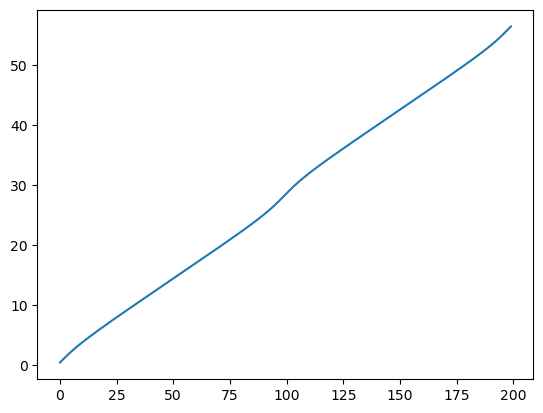

In [12]:
plt.plot(ss_arr)

In [103]:
# what if there is a convention problem?
P_phi_2 = 1/(1/P_phi + 1/P_psi)
print('P_phi_2= {:.2f} hour'.format(P_phi_2/hour))
P_phi_2 = 1/(1/P_phi - 1/P_psi)
print('P_phi_2= {:.2f} hour'.format(P_phi_2/hour))
# does not solve the problem

P_phi_2= 25.69 hour
P_phi_2= 31.85 hour


In [57]:
phi=0
CT0 = makeC_T(psi,theta,phi)

In [58]:
CT0

matrix([[ 6.12323400e-17,  9.83869910e-01,  1.78885438e-01],
        [-1.00000000e+00,  6.02446568e-17,  1.09535740e-17],
        [ 0.00000000e+00, -1.78885438e-01,  9.83869910e-01]])

#### Order of mag estimates for paper

In [124]:
# compute tidal stress in center to order of magnitude 
G = 6.67408E-11 #   m^3 kg^-1 s^-2
M_earth =  5.9722E24 # kg 
R_mean = 185. # m B18?
rho = 2e3  #  kg/m^3
r_peri =  38017.0e3 #  km to m
sig_tidal = G*rho*M_earth*R_mean**2/r_peri**3
print('sig_tidal={:.3f} (Pa)'.format(sig_tidal))
# basically agreeing with rough guess by Hirabayashi+21 who got 0.5 Pa

sig_tidal=0.497 (Pa)


In [125]:
#We compute the central pressure 
M_Apophis = 4.0e10 # kg
P_c = G*M_Apophis**2 * R_mean**-4 * 3.0/(8*np.pi)
print('central pressure P_c {:.2f} Pa'.format(P_c))
# it's about 25 Pa
# this implies that tidal stress could be of order about a percent of central pressure. 

P_c 10.88 Pa


The central pressure at a uniform density sphere
https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/05%3A_Gravitational_Field_and_Potential/5.13%3A_Pressure_at_the_Centre_of_a_Uniform_Sphere
is 
$$P = \frac{2}{3} \pi G \rho^2  a^2 = \frac{2\pi}{3} \left(\frac{3}{4\pi}\right)^2 \frac{GM^2}{a^4}  = \frac{3}{8\pi} \frac{GM^2}{a^4}$$

In [126]:
# compute acceleration and internal stress due to wobble 
a_wobble = omega_eff**2*R_mean
print('a_wobble {:.3e} m/s^2'.format(a_wobble))
sigma_acc = a_wobble*R_mean*rho
print('acceleration stress sigma_acc={:.3f} Pa'.format(sigma_acc))

a_wobble 5.605e-07 m/s^2
acceleration stress sigma_acc=0.207 Pa


### compute volume of Brozovic+18 shape model

In [53]:
# read in shape model Brozovic+18
shapefile = '../shape/apophis_v233s7_vert2_new.obj'

# read in an obj file 
vertex_list = np.zeros(3,dtype=float)
face_list = np.zeros(3,dtype=int)

with open(shapefile) as fp:
    for line in fp:
        ss = line.split(' ')
        #print(ss)
        if (ss[0] =='v'):
            x = float(ss[1])
            y = ss[2]
            z = ss[3]
            vertex_list = np.vstack([vertex_list,np.array([x,y,z],dtype=float)]) 
        if (ss[0] =='f'):
            i = ss[1]
            j = ss[2]
            k = ss[3]
            face_list = np.vstack([face_list,np.array([i,j,k],dtype=int)])
        
vertex_list = vertex_list[1:]
face_list = face_list[1:]
# note faces are indexed from 1 not 0!

In [67]:
len(vertex_list)

2000

In [122]:
# compute the volume of the shape 
def compute_volume(vertices,faces):
    nf = faces.shape[0]
    volume = 0.0;
    for i in range(nf): # note faces are indexed from 1 not 0!
        i1 = faces[i,0]-1  # 
        i2 = faces[i,1]-1
        i3 = faces[i,2]-1 
        #print(i1,i2,i3)
        vec1 = np.squeeze(vertices[i1,:])
        vec2 = np.squeeze(vertices[i2,:])
        vec3 = np.squeeze(vertices[i3,:])
        #print(vec1,vec2,vec3)
        zvec = np.cross(vec1,vec2)
        #print(zvec)
        # a x b dot c is volume of a parallelpiped and we only want a tetrahedron
        vol = np.abs(np.dot(zvec,vec3))/6  # only a tetrahedron! not a parallelpiped!
        volume+= vol
    return volume
        
volume = compute_volume(vertex_list,face_list)
print('volume = {:.3e} km^3'.format(volume) ) # in km^3 for Brozovic18 shape model


volume = 1.983e-02 km^3


In [123]:
volume_m = volume*1e9
print('volume of shape model Apophis B18 {:.3e} m^3'.format(volume_m))
mass_A = 4.0e10  # in kg
density = mass_A/volume_m
print('density {:.1f} kg/m3'.format(density)) # is consistent with values other people like

volume of shape model Apophis B18 1.983e+07 m^3
density 2017.6 kg/m3


### compute spin vector in rad/s and I_D_ratio from Brozovic+18

In [117]:

omega_l = 96.506  # brozovic supplements table in degrees per day
omega_i = 50.799
omega_s = 264.953
I_l_ratio = 0.729
I_i_ratio = 0.947
T = I_l_ratio* omega_l**2 + I_i_ratio*omega_i**2 + omega_s**2  # I_D omega_eff^2/I_s
H2 = np.power(I_l_ratio*omega_l,2)+ np.power(I_i_ratio*omega_i,2) + omega_s**2   
# |H| = I_D omega_eff/I_s
I_D_ratio = H2/T
print('I_D_ratio={:.4f} T_ratio={:.4f}'.format(I_D_ratio,1/I_D_ratio))
# should not be greater than 1
print('Omega = ({:.4e},{:.4e},{:.4e}) rad/s'.format(omega_l/degreeperday, \
                omega_i/degreeperday, omega_s/degreeperday))

I_D_ratio=0.9752 T_ratio=1.0254
Omega = (1.9495e-05,1.0262e-05,5.3522e-05) rad/s


In [ ]:
# dead below

In [56]:
def makeC_T(psi,theta,phi):
    CT = np.matrix([[np.cos(phi)*np.cos(psi)-np.sin(phi)*np.cos(theta)*np.sin(psi),\
           np.sin(phi)*np.cos(psi)+np.cos(phi)*np.cos(theta)*np.sin(psi),\
           np.sin(theta)*np.sin(psi) ],\
          [-np.cos(phi)*np.sin(psi)-np.sin(phi)*np.cos(theta)*np.cos(psi),\
           -np.sin(phi)*np.sin(psi)+np.cos(phi)*np.cos(theta)*np.cos(psi),\
            np.sin(theta)*np.cos(psi)],\
          [ np.sin(phi)*np.sin(theta),\
           -np.cos(phi)*np.sin(theta),\
            np.cos(theta)]])
    return CT